# NHL Data Analysis
  We have taken NHL game data form the last 6 years of games and will be analyzing it in order to answer our research questions
### Research Questions
    - Which NHL Teams have been statistcally the most dominate compared to achieved results
    - For each NHL Team, who has had the most "Successful Tenure"
    - Does shift length have any correlation to goals scored by NHL teams - is the 50 second shift really the most ideal?
---
Please view both of our EDA's beforehand for a little more context and understanding of what will be doing!

### Loading Preliminary functions

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas_profiling
from pandas_profiling import ProfileReport
import sys
sys.path.append('..')
from scripts import ProjectFunctions as pf

### Importing Data Lists
The next line we are just importing the data from our local repositorys, this can be changed to a url or any other method for replicaton
- The [NHL DATA is from this Kaggle page.](https://www.kaggle.com/martinellis/nhl-game-data) for convienance

All data is provided and can be sourced from the NHL’s API, unofficial documentation can be found on Drew Hynes’ gitlab here: https://gitlab.com/dword4/nhlapi/-/blob/master/stats-api.md

In [2]:
k = "C:/Users/keati/Documents/Cosc301/Nhl_Data/game_teams_stats.csv"
l = "C:/Users/keati/Documents/Cosc301/Nhl_Data/team_info.csv"
z = "C:/Users/keati/Documents/Cosc301/Nhl_Data/game.csv"
adress1 = "C:/Users/keati/Documents/Cosc301/Nhl_Data/game_shifts.csv"
adress2 = "C:/Users/keati/Documents/Cosc301/Nhl_Data/game_skater_stats.csv"

df1 = pf.CoachData(k)
df2 = pf.TeamData(k)
df3 = pf.TeamList(l)
df11 = pf.ShiftsClean(adress1)
df12 = pf.StatsClean(adress2)

df11['game_id']=df11['game_id'].values.astype(str)
df11['player_id']=df11['player_id'].values.astype(str)
df11['ID']=df11['game_id'].str.cat(df11['player_id'],sep='-')

df12['game_id']=df12['game_id'].values.astype(str)
df12['player_id']=df12['player_id'].values.astype(str)
df12['ID']=df12['game_id'].str.cat(df12['player_id'],sep='-')
df5 = df12.drop(['game_id','player_id'], axis='columns')

df6 = pf.GroupPlayer(df11)

df=pd.merge(df6,df5,how='inner',on ='ID')
df=df[['ID','shiftlength','team_id','shots','Goals','Assists','plusMinus','timeOnIce']]
Coach_df = pd.merge(df3,df1, how='inner')
total_df = pd.concat([df3,df2],axis=1).reindex(df2.index)

## Successful Tenure

To start off our analysis of the most dominate team I first wanted to look at each individual team and figure out who on which coach has had the best run on each team

In [3]:
step1 = pd.merge(pd.read_csv(k),pd.read_csv(z), how='inner')
step2 = step1.groupby(['head_coach','team_id']).sum().reset_index().drop(['game_id', 'home_team_id','season','away_team_id','venue_time_zone_offset','goals'], axis = 'columns')
df4 = pd.merge(df3,step2, how='inner')
Total = df4.sort_values('won').drop_duplicates('teamName', keep = 'last').reset_index(drop=True)

- From this dataframe I was able to plot and see which had the most amount of wins with each individual team and started to form some other advanced stats for the analysis

The average wins per head coach is 382 games


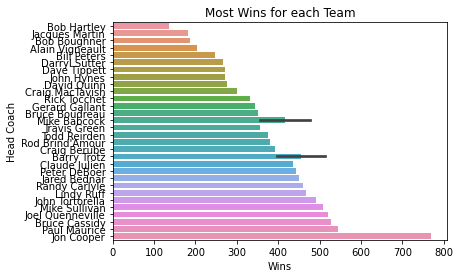

In [4]:
Most_wins = Total.sort_values('won').drop_duplicates('teamName', keep = 'last').reset_index(drop=True)
sns.barplot(x='won',y='head_coach',data=Most_wins,linewidth=1)
plt.xlabel("Wins")
plt.ylabel("Head Coach")
plt.title("Most Wins for each Team")
print('The average wins per head coach is {:.0f} games'.format(Total['won'].mean()))

Moving on from this base Information I wanted to see what made each coach with there respective made them so successful.

To achieve this I created another Three columns figuring out the each teams total goals, Total goal percentage and power play goal percentage

I feel these stats are important as it shows eachs teams chance to score on a shot and the amount of times you can except them to score

In [5]:
Total['Total Goals'] = Total['away_goals'] + Total['home_goals']

In [6]:
Total['Goal Percentage in %'] = (((Total['away_goals'] + Total['home_goals'])/Total['shots'])*100)
Total['PPG Goal Percentage in %'] = ((Total['powerPlayGoals']/Total['powerPlayOpportunities'])*100)

In [7]:
Total.select_dtypes(include='number').mean()


team_id                        18.656250
won                           382.343750
shots                       22665.625000
hits                        15850.468750
pim                          7217.343750
powerPlayOpportunities       2456.406250
powerPlayGoals                474.906250
faceOffWinPercentage        29613.115625
giveaways                    6912.250000
takeaways                    5239.750000
blocked                      9661.750000
away_goals                   2020.843750
home_goals                   2228.000000
Total Goals                  4248.843750
Goal Percentage in %           18.847894
PPG Goal Percentage in %       19.397710
dtype: float64

The average goals scored in % for every team is 18.85% 


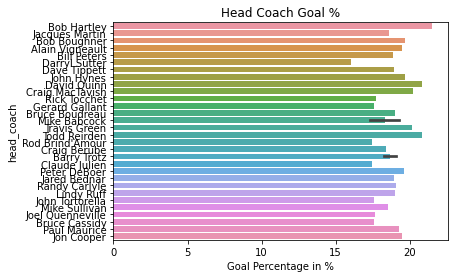

In [8]:

sns.barplot(x='Goal Percentage in %',y='head_coach',data=Total,linewidth=0.2)
plt.title("Head Coach Goal %")
print('The average goals scored in % for every team is {:.2f}% '.format(Total['Goal Percentage in %'].mean()))

The average PPG scored in % for every team is 19.40%


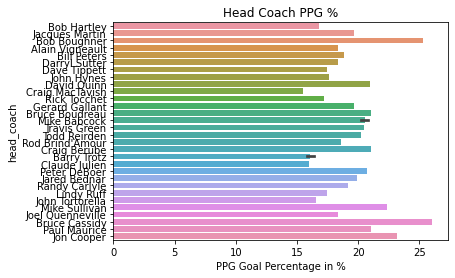

In [9]:
sns.barplot(x='PPG Goal Percentage in %',y='head_coach',data=Total,linewidth=0.2)
plt.title("Head Coach PPG %")
print('The average PPG scored in % for every team is {:.2f}%'.format(Total['PPG Goal Percentage in %'].mean()))

## Most dominate

lastly to explore the most dominate coach, We will be exploring the stats from each team regardless off there overall achieved results in the last 8 years. This is due to the fact that not every team has played the same number of gaames so the wins category can be skewed. This is noted with the Golden Knights have not been in the league as long as every other team.

To work around this I am going to create a weighted total including shots, hits, takeaways and blocked shots and goals. These stats are more relative to the overal play of a team rather than just goals and if they win.

The scores will be computed with:
 - 40% Goals - Need to Score to win
 - 20% Shots - Generates offence
 - 30% takeaway - Generates a turn over and gives the team the play
 - 10% Hits - defensive statistic, defending your zone
 - 20% block shots - defensive statistic
 

The average amount of games won for every team is 777 games


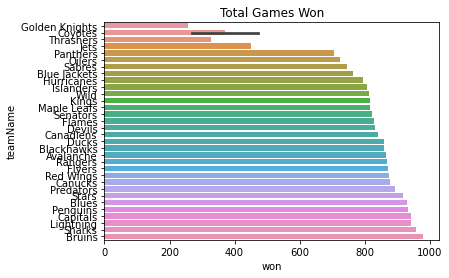

In [10]:
pd_df = total_df.sort_values(['won']).reset_index(drop=True)
sns.barplot(x='won',y='teamName',data=pd_df,linewidth=1)
plt.title("Total Games Won")
print('The average amount of games won for every team is {:.0f} games'.format(total_df['won'].mean()))

To work around this I am going to create a weighted total including shots, hits, takeaways and blocked shots as these stats are more relative to the overal play of a team rather than goals.
The scores will be computed with:
 - 40% Shots - Help a team win  with offense
 - 30% takeaway - Generates a turn over and gives the team the play
 - 10% Hits - defensive statistic, defending your zone
 - 20% block shots - defensive statistic
 
 

In [11]:
Total['Weighted Score'] = (0.3*Total['shots'] + 0.2*Total['takeaways'] + 0.1*Total['hits'] + 0.1*Total['blocked']+0.4*Total['Total Goals'])
Sample = pd.DataFrame(Total.groupby("teamName")['Weighted Score'].mean().sort_values(ascending=False).reset_index())
Sample

,teamName,Weighted Score
0,Lightning,20756.9
1,Jets,17377.3
2,Penguins,16383.4
3,Canadiens,16047.4
4,Blue Jackets,15881.7
5,Blackhawks,15594.7
6,Bruins,15398.6
7,Avalanche,15186.4
8,Predators,14934.0
9,Ducks,14596.7


From this result you can see how Tampa Bay is near the one team using a weighted score, It is also is good to note that although the Golden Knights have not played nearly as many games as the rest of the teams they are on the top end of the league.

To Conclude I would say the best team and coach over the last couple of years is John Cooper with the Tampa Bay Lighting. For easbily I summerized his stats below

In [12]:
print("Summary of John Cooper and Tampa Bay")
display(Total.iloc[31])

Summary of John Cooper and Tampa Bay


team_id                             14
shortName                    Tampa Bay
teamName                     Lightning
head_coach                  Jon Cooper
won                                770
shots                          37834.0
hits                           31453.0
pim                            12530.0
powerPlayOpportunities          3841.0
powerPlayGoals                   891.0
faceOffWinPercentage           60441.1
giveaways                      10378.0
takeaways                       8249.0
blocked                        16604.0
away_goals                        3566
home_goals                        3812
Total Goals                       7378
Goal Percentage in %         19.500978
PPG Goal Percentage in %     23.197084
Weighted Score                 20756.9
Name: 31, dtype: object

## Shift Length
I want to explore the most ideal shift length for NHL players to achieve maximal results. From when I was playing hockey our coaches would always tell us to take shorter shifts and aim for around 50 seconds. I would like to see if their ideal shift length was infact correct and if it can be proven through data analysis.

First we will show the distribution of NHL shift Lengths from this dataset:

The average NHL player's shiftlength is 46 seconds


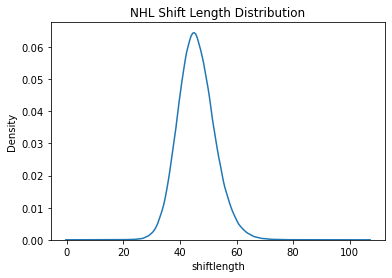

In [13]:
sns.kdeplot(df['shiftlength'])
plt.title("NHL Shift Length Distribution")
print("The average NHL player's shiftlength is {:.0f} seconds".format(df['shiftlength'].mean()))

It's easy to see that most shifts are within the 30-75 second range with the most around 45 seconds.

Next we will look at the goals and shots taken at given shift lengths:

With the average shift being 46 seconds each player approximetly gets 2 shots


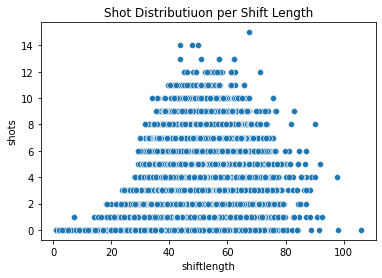

In [14]:
sns.scatterplot(data=df,x='shiftlength', y='shots')
plt.title("Shot Distributiuon per Shift Length")
print("With the average shift being 46 seconds each player approximetly gets {:.0f} shots".format(df['shots'].mean()))

In average shifts 46 seconds each player approximetly will achieve 0.19 goals


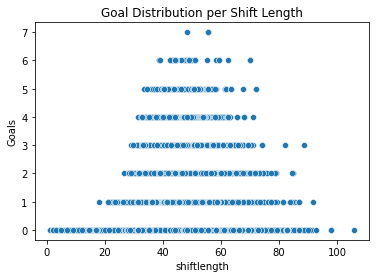

In [19]:
sns.scatterplot(data=df,x='shiftlength', y='Goals')
plt.title("Goal Distribution per Shift Length")
print("In average shifts 46 seconds each player approximetly will achieve {:.2f} goals".format(df['Goals'].mean()))

From these two plots we can see that the highest goals and shots achieved are found within the same shift range of 40 to 60 seconds and the results follow a normal distribution curve. 

After seeing that these shift ranges are the most efficient, it begs the question: So what shift lengths are averagely used by teams throughout the NHL. This can be shown by averaging the shift lengths for each team and graphing them as follows:

Text(0.5, 1.0, 'Avergae Shift Length by NHL Team')

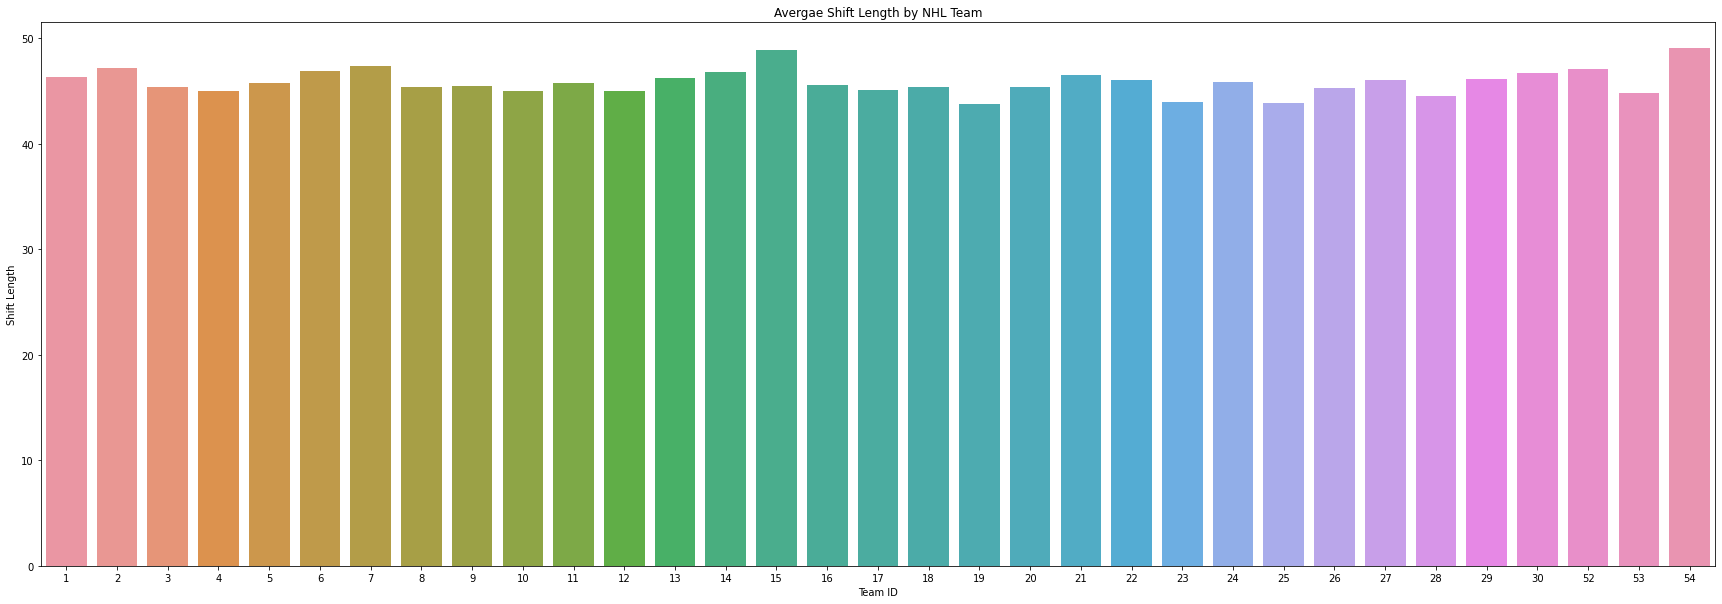

In [16]:
shiftsbyteam = df.groupby(['team_id']).mean().reset_index()
fig, ax = plt.subplots(figsize=(30,10))
sns.barplot(x='team_id',y='shiftlength',data=shiftsbyteam)
plt.xlabel("Team ID")
plt.ylabel("Shift Length")
plt.title("Avergae Shift Length by NHL Team")

This Graph shows that all NHL Teams analyzed within this data have an average shift length of 40-50 seconds which keeps them within the ideal range identified above.

The data can be further extrapolated to see which shift length within the range has the most goals and shots.

Text(0.5, 1.0, 'Average Goals scored by Shift Length')

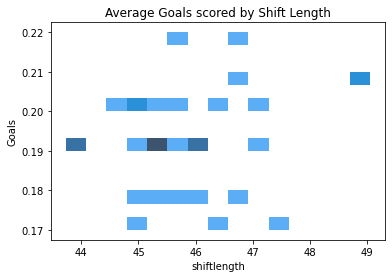

In [17]:
y = shiftsbyteam.round(decimals=2)
sns.histplot(data=y, x='shiftlength', y='Goals', bins=15 )
plt.title("Average Goals scored by Shift Length")

From this data it is easy to see that the majority of goals are scored in shifts ranging between 45 to 46 seconds. This may not be the 50 second shifts I was anticipating, however, the 45 second shifts do align with his mentality so I do believe that he was correct in his approach and am glad that I could prove this throughout this data set.